In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
import nn_classification as nn
from xgboost_classifier import *


Using TensorFlow backend.
/Applications/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading data
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
#parameter setting
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='docEmbeddings_30_load_all.d2v'

In [4]:
#Parameter defined for doc2vec model
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_30_load_all.d2v


In [7]:
#prepare the feature vectors
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([-4.32804871, -1.51728463, -1.11980414, -1.48884988, -1.94485927,
        2.92375898,  0.50411427, -1.12256765,  3.63756609,  0.98047012,
       -3.59505153, -1.69239998,  1.08154798,  0.04358532, -1.45718324,
       -1.40607941, -0.81513387, -1.83771491,  0.84762865,  1.21229076,
        2.47014523, -2.76897311,  1.76767576,  0.63634545, -1.18918824,
        0.41207117,  0.46613771, -0.66748267, -0.08578082,  0.74831831,
       -0.27361712, -1.59590268, -0.68817914,  1.80353093, -2.18088555,
       -0.95929134,  3.10893011,  1.76786911, -0.6726135 ,  1.6783632 ,
        0.86585337,  2.32940316,  3.42221165, -1.29582059,  1.10946131,
       -1.03413177,  1.08570337, -1.0144273 ,  0.31510681,  0.28210998,
        2.33720469,  0.54392654, -2.83733749, -1.03502595, -0.16337521,
       -3.04194999, -0.25847396, -2.89910054,  1.95583844,  2.05173278,
       -0.68942761,  2.17256355, -2.50274634,  2.23825169, -2.29581237,
        4.42594433,  2.62937164,  2.88882828, -0.28914687, -2.05

In [9]:
#concatenate the doc feature vectors
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   7.43920261e-19,   1.86967768e-19,
         2.36987218e-29,   3.78288394e-25,   7.97142704e-23,
        -1.06895319e-20,   6.87926690e-21,   4.36854413e-21,
        -4.04470778e-21,   8.91881464e-21,   6.59040569e-18,
         5.67979623e-19,  -3.15512997e-18,  -9.40491899e-18,
        -6.36407932e-18,  -3.20292165e-18,   9.53349364e-18,
         7.28293876e-18,   2.84124514e-17,  -1.85442723e-17,
         1.28733104e-17,   1.05102497e-17,   4.67448189e-17,
        -8.77125342e-21])

In [11]:
# this is the 4 layer full-connected nerual network model
model = nn.nn_baseline_model(TEXT_INPUT_DIM, GENE_INPUT_DIM, GENE_INPUT_DIM)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               64256     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 151,337
Trainable params: 151,337
Non-trainable params: 0
_________________________________________________________________


/Users/qqu0127/Desktop/CS249/master/Personalized-Medicine-Redefining-Cancer-Treatment/src/nn_classification.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=250, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
/Users/qqu0127/Desktop/CS249/master/Personalized-Medicine-Redefining-Cancer-Treatment/src/nn_classification.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, init='normal', activation='relu'))
/Users/qqu0127/Desktop/CS249/master/Personalized-Medicine-Redefining-Cancer-Treatment/src/nn_classification.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  model.add(Dense(80, init='normal', activation='relu'))
/Users/qqu0127/Desktop/CS249/master/Personalize

begin training

Train on 3320 samples, validate on 369 samples
Epoch 1/2
3320/3320 [==============================] - 1s 335us/step - loss: 2.0069 - acc: 0.2440 - val_loss: 1.7401 - val_acc: 0.4092
Epoch 2/2
3320/3320 [==============================] - 0s 61us/step - loss: 1.6782 - acc: 0.3928 - val_loss: 1.5093 - val_acc: 0.4472
Training accuracy: 39.28% / Best validation accuracy: 44.72%
Train on 3320 samples, validate on 369 samples
Epoch 1/2
3320/3320 [==============================] - 0s 60us/step - loss: 1.4671 - acc: 0.4575 - val_loss: 1.3139 - val_acc: 0.5583
Epoch 2/2
3320/3320 [==============================] - 0s 82us/step - loss: 1.3548 - acc: 0.5184 - val_loss: 1.2134 - val_acc: 0.5528
Training accuracy: 51.84% / Best validation accuracy: 55.28%
Train on 3320 samples, validate on 369 samples
Epoch 1/2
3320/3320 [==============================] - 0s 64us/step - loss: 1.2776 - acc: 0.5334 - val_loss: 1.1617 - val_acc: 0.5745
Epoch 2/2
3320/3320 [=============================

Training accuracy: 74.55% / Best validation accuracy: 66.67%
Train on 3320 samples, validate on 369 samples
Epoch 1/2
3320/3320 [==============================] - 0s 78us/step - loss: 0.6774 - acc: 0.7407 - val_loss: 0.8821 - val_acc: 0.6721
Epoch 2/2
3320/3320 [==============================] - 0s 80us/step - loss: 0.6902 - acc: 0.7298 - val_loss: 0.8984 - val_acc: 0.6477
Training accuracy: 72.98% / Best validation accuracy: 66.67%
Train on 3320 samples, validate on 369 samples
Epoch 1/2
3320/3320 [==============================] - 0s 69us/step - loss: 0.6680 - acc: 0.7476 - val_loss: 0.9090 - val_acc: 0.6802
Epoch 2/2
3320/3320 [==============================] - 0s 66us/step - loss: 0.6752 - acc: 0.7325 - val_loss: 0.8983 - val_acc: 0.6694
Training accuracy: 73.25% / Best validation accuracy: 66.94%
Train on 3320 samples, validate on 369 samples
Epoch 1/2
3320/3320 [==============================] - 0s 65us/step - loss: 0.6548 - acc: 0.7527 - val_loss: 0.8989 - val_acc: 0.6612
Epoch 

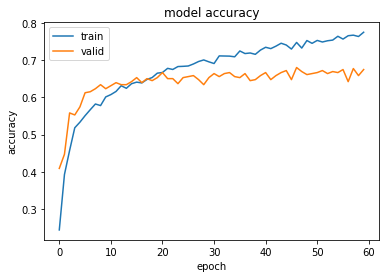

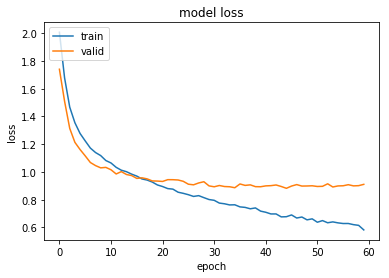

In [12]:
model = nn.train_nn_model(model, train_set, encoded_y, filename = 'demo_NN.h5')
y_predict = model.predict_proba(test_set)

In [15]:
util.savesubmisstion(y_predict, test_x, filename = "submission_demo.csv")